# Specific versions and imports

In [1]:
# Pip install method (recommended)
%pip install ultralytics
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 18.2 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import csv
import tensorflow as tf
import keras as keras
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import shutil
import squarify
import cv2
import matplotlib.image as mpimg
import seaborn as sns
import sklearn
import ultralytics
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

sns.set_style('darkgrid')

%matplotlib inline

2024-12-29 02:40:28.748457: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-29 02:40:28.748605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-29 02:40:28.885122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Reproducibility
random_seed = 42
random.seed(random_seed)

# Show versions of the imported libraries
pd.DataFrame({
    'Library': ['ultralytics','tensorflow','keras','csv','cv2','pandas','matplotlib','sklearn','sns'], 
    'Version': [ultralytics.__version__,tf.__version__,keras.__version__,csv.__version__,cv2.__version__,pd.__version__,matplotlib.__version__,sklearn.__version__,sns.__version__]
})

Library Version
0  ultralytics  8.3.55
1   tensorflow  2.15.0
2        keras  2.15.0
3          csv     1.0
4          cv2   4.9.0
5       pandas   2.2.0
6   matplotlib   3.7.4
7      sklearn   1.2.2
8          sns  0.12.2

# Common functions

In [4]:
def csv_to_dataframe(csv_filepath, columns_name):    
    df = pd.read_csv(csv_filepath, names=columns_name, header=0)
    return df

def calc_percentage(df_total, df_part,file_id_column):
    part = len(df_part[file_id_column].unique())
    total = len(df_total[file_id_column].unique())
    return (part / total) * 100

def dict_to_yaml(data):
    yaml_lines = []
    for key, value in data.items():
        if key == 'format':
            if value == 'line_break':
                 yaml_lines.append('')
        elif isinstance(value, list):
            yaml_lines.append(f"{key}: {value}")
        else:
            yaml_lines.append(f"{key}: {value}")
    return '\n'.join(yaml_lines)

def create_yaml_data(yaml_file_name,output_dir,data):        
    yaml_content = dict_to_yaml(data)
    output_path = os.path.join(output_dir, f'{yaml_file_name}.yaml')
    os.makedirs(output_dir, exist_ok=True)
    with open(output_path, 'w') as file:
        file.write(yaml_content)
    print(f'YAML file created successfully in {output_path}.')
    
def convert_bbox_to_yolo(x, y, width, height, img_width, img_height):
    x_center = (x + width / 2) / img_width
    y_center = (y + height / 2) / img_height
    width /= img_width
    height /= img_height
    return x_center, y_center, width, height

def dataframe_yolofiles(df, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)    
    data = {}    
    for index, row in df.iterrows():
        image_id = row['image_id']
        img_width = int(row['width'])
        img_height = int(row['height'])
        bbox = eval(row['bbox'])
        x, y, width, height = bbox
        x_center, y_center, norm_width, norm_height = convert_bbox_to_yolo(x, y, width, height, img_width, img_height)        
        if image_id not in data:
            data[image_id] = []        
        data[image_id].append(f"0 {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}")    
    for image_id, bboxes in data.items():
        output_file_path = os.path.join(output_dir, os.path.splitext(image_id)[0] + ".txt")
        with open(output_file_path, 'w') as f:
            for bbox in bboxes:
                f.write(bbox + "\n")
    print(f'Total text files created in: {output_dir}')
                
def move_images_to_directory(df, root_dir, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)    
    unique_image_ids = df['image_id'].unique()    
    for image_id in unique_image_ids:
        source_path = os.path.join(root_dir, image_id)
        target_path = os.path.join(target_dir, image_id)        
        if os.path.exists(source_path):
            shutil.copy(source_path, target_path)
        else:
            print(f"Warning: Image {image_id} not found on path {source_path}")
    print(f'Total images moved to: {target_dir}')
    
def leaf_detect(img_path,model):
    img = cv2.imread(img_path)
    detect_result = model(img)
    detect_img = detect_result[0].plot()
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)    
    return detect_img

def plot_images_with_detections(images_dir, labels_dir, num_images=16, grid_size=(4, 4), figsize=(16, 16)):
    image_files = os.listdir(images_dir)
    image_files.sort()
    images_forshow = image_files[:num_images]
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
    for i, image_file in enumerate(images_forshow):
        row = i // grid_size[1]
        col = i % grid_size[1]
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path)
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, "r") as f:
            labels = f.read().strip().split("\n")
        for label in labels:
            if len(label.split()) != 5:
                continue
            class_id, x_center, y_center, width, height = map(float, label.split())
            x_min = int((x_center - width / 2) * image.shape[1])
            y_min = int((y_center - height / 2) * image.shape[0])
            x_max = int((x_center + width / 2) * image.shape[1])
            y_max = int((y_center + height / 2) * image.shape[0])
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (250, 221, 47), 3)
        axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[row, col].axis('off')
    plt.show()

def show_csv_results(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
    sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
    sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
    sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
    sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
    sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
    sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
    sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
    sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
    sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
    sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])
    axs[0,0].set(title='Train Box Loss')
    axs[0,1].set(title='Train Class Loss')
    axs[1,0].set(title='Train DFL Loss')
    axs[1,1].set(title='Metrics Precision (B)')
    axs[2,0].set(title='Metrics Recall (B)')
    axs[2,1].set(title='Metrics mAP50 (B)')
    axs[3,0].set(title='Metrics mAP50-95 (B)')
    axs[3,1].set(title='Validation Box Loss')
    axs[4,0].set(title='Validation Class Loss')
    axs[4,1].set(title='Validation DFL Loss')
    plt.suptitle('Training Metrics and Loss', fontsize=24)
    plt.subplots_adjust(top=0.8)
    plt.tight_layout()
    plt.show()    
    
def show_directory_images(directory, num_images, rows=3, columns=3):
    archivos_imagen = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    fig = plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(archivos_imagen))):
        img_path = os.path.join(directory, archivos_imagen[i])
        img = cv2.imread(img_path)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.imshow(img)
        ax.axis('off')
    for j in range(num_images, rows * columns):
        ax = fig.add_subplot(rows, columns, j + 1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def show_metrics(metrics):
    # Create the barplot
    ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])
    # Set the title and axis labels
    ax.set_title('YOLO Evaluation Metrics')
    ax.set_xlabel('Metric')
    ax.set_ylabel('Value')
    # Set the figure size
    fig = plt.gcf()
    fig.set_size_inches(8, 6)
    # Add the values on top of the bars
    for p in ax.patches:
        ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    # Show the plot
    plt.show()    
    
def show_detections(images_dir, num_images=16, rows=4, columns=4):
    image_files = os.listdir(images_dir)
    selected_images = random.sample(image_files, num_images)
    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15, 15))
    for i, img_file in enumerate(selected_images):
        row_idx = i // columns
        col_idx = i % columns
        img_path = os.path.join(images_dir, img_file)
        detect_img = leaf_detect(img_path, model)
        axes[row_idx, col_idx].imshow(detect_img)
        axes[row_idx, col_idx].axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()
    
def show_image(img_path):    
    img = mpimg.imread(img_path)
    fig, ax = plt.subplots(figsize = (15, 15))
    ax.imshow(img)
    ax.axis('off')
    plt.show()    

# Convert Dataset CSV to format Yolo

## Division into train(80%), validation(10%) and test(10%)

In [5]:
columns_name = ['image_id', 'width', 'height', 'bbox']
csv_filepath = '/kaggle/input/leaf-detection/train.csv'
annotations = csv_to_dataframe(csv_filepath,columns_name)
df = pd.DataFrame(annotations)

# Split the DataFrame into training(80%) and validation with test(20%) based on the unique file names
unique_filenames = df['image_id'].unique()
train_filenames, val_test_filenames = train_test_split(unique_filenames, test_size=0.2, random_state=random_seed)
train_df = df[df['image_id'].isin(train_filenames)]

# 10% for validation and 10% for test
val_filenames, test_filenames = train_test_split(val_test_filenames, test_size=0.5, random_state=random_seed)
val_df = df[df['image_id'].isin(val_filenames)]
test_df = df[df['image_id'].isin(test_filenames)]

## Show training dataframe data

In [6]:
train_percentage = calc_percentage(df,train_df,'image_id')
print(f'Elements in train_df({train_percentage}%):',len(train_df['image_id'].unique()))
train_df.head()

Elements in train_df(80.0%): 904


image_id  width  height                  bbox
0  LEAF_0009.jpg   1024    1024  [473, 273, 289, 335]
1  LEAF_0009.jpg   1024    1024  [588, 516, 272, 318]
2  LEAF_0009.jpg   1024    1024  [510, 780, 218, 244]
3  LEAF_0009.jpg   1024    1024  [766, 822, 246, 201]
4  LEAF_0009.jpg   1024    1024    [1, 813, 240, 211]

## Show validation dataframe data

In [7]:
val_percentage = calc_percentage(df,val_df,'image_id')
print(f'Elements in val_df({val_percentage}%):',len(val_df['image_id'].unique()))
val_df.head()

Elements in val_df(10.0%): 113


image_id  width  height                  bbox
172  LEAF_0012.jpg   1024    1024  [498, 185, 192, 301]
173  LEAF_0012.jpg   1024    1024  [357, 182, 154, 287]
174  LEAF_0012.jpg   1024    1024  [328, 482, 185, 243]
175  LEAF_0012.jpg   1024    1024  [503, 498, 173, 254]
176  LEAF_0012.jpg   1024    1024  [123, 255, 111, 203]

## Show test dataframe data

In [8]:
test_percentage = calc_percentage(df,test_df,'image_id')
print(f'Elements in test_df({test_percentage}%):',len(test_df['image_id'].unique()))
test_df.head()

Elements in test_df(10.0%): 113


image_id  width  height                  bbox
307  LEAF_0019.jpg   1024    1024  [722, 298, 302, 209]
308  LEAF_0019.jpg   1024    1024  [747, 459, 277, 166]
309  LEAF_0019.jpg   1024    1024  [870, 700, 154, 324]
310  LEAF_0019.jpg   1024    1024  [696, 655, 171, 200]
311  LEAF_0019.jpg   1024    1024  [421, 810, 222, 214]

## Creation of the data.yaml file of the Yolo dataset

In [9]:
output_dir = '/kaggle/working/yolo_dataset_leafdetection'
yaml_file_name = 'data'
yaml_data = {
    'train': f'{output_dir}/train/images',
    'val': f'{output_dir}/valid/images',
    'test': f'{output_dir}/test/images',
    'format':'line_break',
    'nc': 1,
    'names': ['leaf']
}

create_yaml_data(yaml_file_name,output_dir,yaml_data)

YAML file created successfully in /kaggle/working/yolo_dataset_leafdetection/data.yaml.


## Creation of text and image files in the corresponding directories

In [10]:
paths_all_images = '/kaggle/input/leaf-detection/train/'

# Data for train
txt_files_train = f'{output_dir}/train/labels'
img_files_train = f'{output_dir}/train/images'
move_images_to_directory(train_df, paths_all_images, img_files_train)
dataframe_yolofiles(train_df, txt_files_train)

# Data for validation
txt_files_val = f'{output_dir}/valid/labels'
img_files_val = f'{output_dir}/valid/images'
move_images_to_directory(val_df, paths_all_images, img_files_val)
dataframe_yolofiles(val_df, txt_files_val)

# Data for test
txt_files_test = f'{output_dir}/test/labels'
img_files_test = f'{output_dir}/test/images'
move_images_to_directory(test_df, paths_all_images, img_files_test)
dataframe_yolofiles(test_df, txt_files_test)

Total images moved to: /kaggle/working/yolo_dataset_leafdetection/train/images
Total text files created in: /kaggle/working/yolo_dataset_leafdetection/train/labels
Total images moved to: /kaggle/working/yolo_dataset_leafdetection/valid/images
Total text files created in: /kaggle/working/yolo_dataset_leafdetection/valid/labels
Total images moved to: /kaggle/working/yolo_dataset_leafdetection/test/images
Total text files created in: /kaggle/working/yolo_dataset_leafdetection/test/labels


# Dataset Yolo Overview

## Visualizing Sample Images with Corresponding Annotations

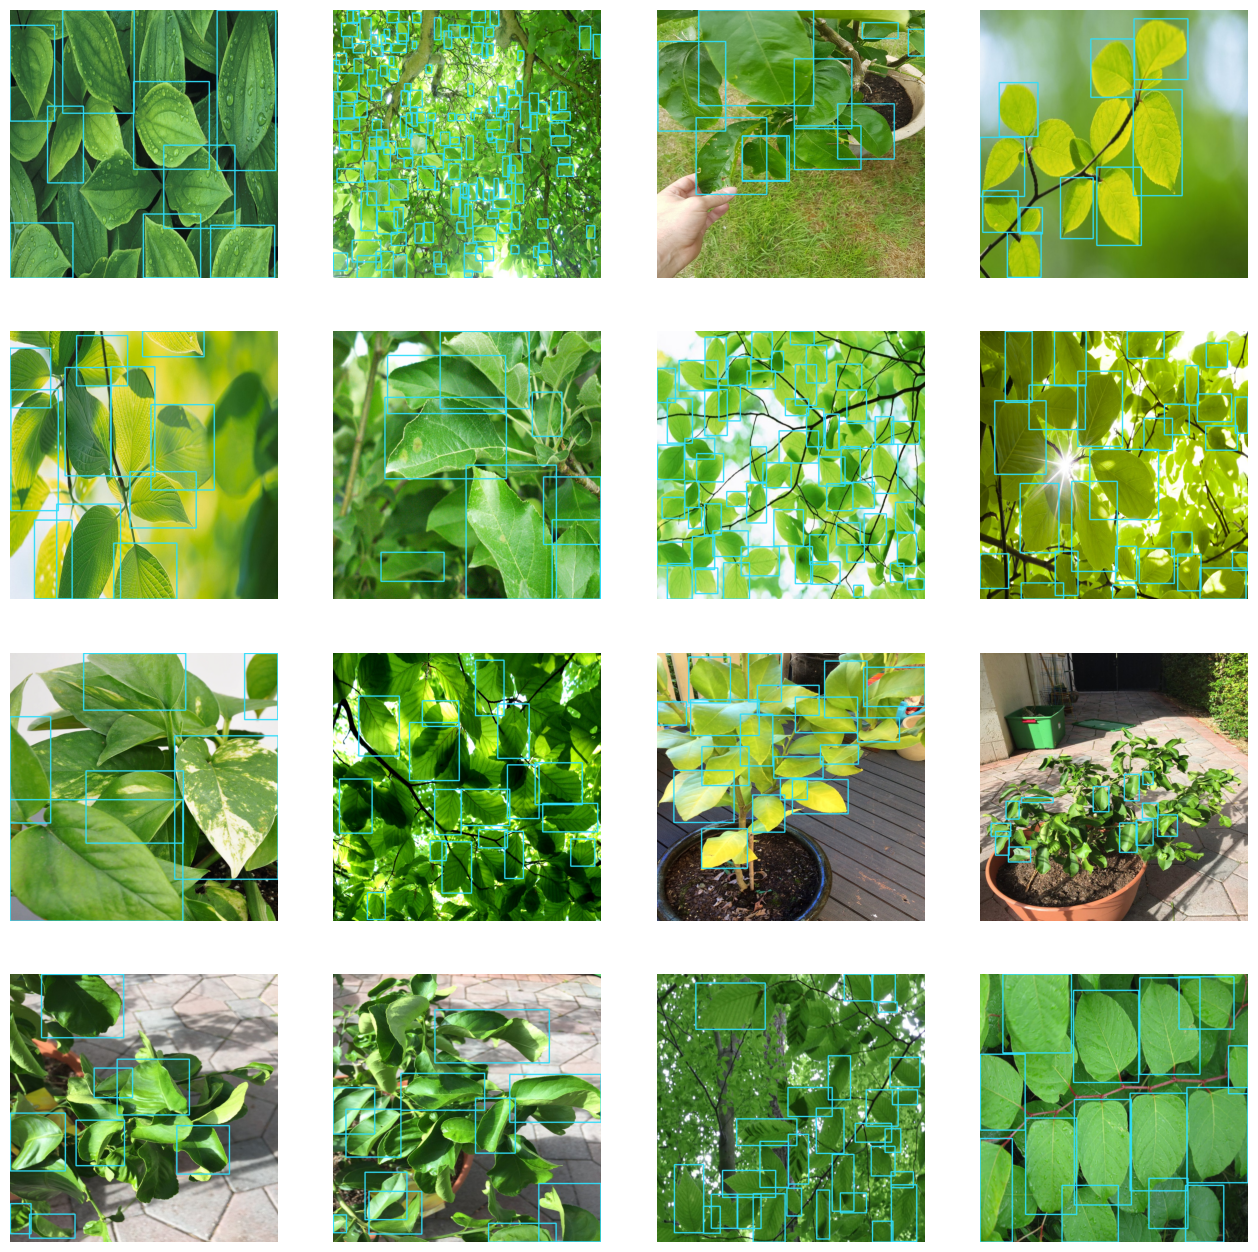

In [11]:
# Define the paths to the images and labels directories
train_images = "/kaggle/working/yolo_dataset_leafdetection/train/images"
train_labels = "/kaggle/working/yolo_dataset_leafdetection/train/labels"

test_images = "/kaggle/working/yolo_dataset_leafdetection/test/images"
test_labels = "/kaggle/working/yolo_dataset_leafdetection/test/labels"

val_images = "/kaggle/working/yolo_dataset_leafdetection/valid/images"
val_labels = "/kaggle/working/yolo_dataset_leafdetection/valid/labels"

plot_images_with_detections(train_images, train_labels)

## Image Metadata

In [12]:
# Load an image using OpenCV
image = cv2.imread("/kaggle/working/yolo_dataset_leafdetection/train/images/LEAF_1171.jpg")

# Get the size of the image
height, width, channels = image.shape
print(f"The image has dimensions {width}x{height} and {channels} channels.")

The image has dimensions 1024x1024 and 3 channels.


# Model Training
To train the model with ultralytics, an apikey is required that will be requested at the time of executing the training, the site where this apikey will be obtained is at https://wandb.ai/authorize

In [13]:
 # Loading a pretrained model
model = YOLO('yolov8n.pt')

# Training the model
model.train(data = '/kaggle/working/yolo_dataset_leafdetection/data.yaml',
            epochs = 60,
            imgsz = height,
            seed = random_seed,
            batch = 8,
            workers = 4)

100%|██████████| 6.25M/6.25M [00:00<00:00, 105MB/s]


Ultralytics 8.3.55 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/yolo_dataset_leafdetection/data.yaml, epochs=60, time=None, patience=100, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

100%|██████████| 755k/755k [00:00<00:00, 26.7MB/s]
2024-12-29 02:41:03,174	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-29 02:41:03,834	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 99.0MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/yolo_dataset_leafdetection/train/labels... 904 images, 0 backgrounds, 0 corrupt: 100%|██████████| 904/904 [00:00<00:00, 1318.07it/s]

train: New cache created: /kaggle/working/yolo_dataset_leafdetection/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/yolo_dataset_leafdetection/valid/labels... 113 images, 0 backgrounds, 0 corrupt: 100%|██████████| 113/113 [00:00<00:00, 1603.99it/s]

val: New cache created: /kaggle/working/yolo_dataset_leafdetection/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.92G       1.47      2.314      1.752         47       1024: 100%|██████████| 113/113 [00:27<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

                   all        113        532       0.45      0.457      0.396      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.08G      1.487       2.04      1.777         51       1024: 100%|██████████| 113/113 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]

                   all        113        532      0.203      0.338       0.13     0.0577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.46G      1.514      1.974      1.802         50       1024: 100%|██████████| 113/113 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]

                   all        113        532        0.4      0.434      0.343      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.09G      1.523      1.896      1.789         95       1024: 100%|██████████| 113/113 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.03it/s]

                   all        113        532      0.421      0.459      0.407      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60       3.4G        1.5      1.757      1.799         68       1024: 100%|██████████| 113/113 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.41it/s]

                   all        113        532      0.502      0.404      0.395      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      2.87G      1.493      1.744      1.787         44       1024: 100%|██████████| 113/113 [00:23<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.44it/s]


                   all        113        532      0.386      0.462      0.375      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60       3.5G      1.446      1.662      1.739         60       1024: 100%|██████████| 113/113 [00:23<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.15it/s]


                   all        113        532      0.505      0.427      0.416      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.51G      1.425      1.586      1.716         44       1024: 100%|██████████| 113/113 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.18it/s]

                   all        113        532      0.473      0.526      0.459      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.89G       1.43      1.604      1.732         43       1024: 100%|██████████| 113/113 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]

                   all        113        532      0.489      0.517      0.488      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      4.05G      1.384      1.498      1.682         66       1024: 100%|██████████| 113/113 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]

                   all        113        532      0.508      0.485      0.475      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.98G      1.417       1.54      1.704         40       1024: 100%|██████████| 113/113 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.47it/s]

                   all        113        532       0.51      0.515      0.485      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.34G       1.39      1.453      1.693         77       1024: 100%|██████████| 113/113 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.30it/s]

                   all        113        532       0.55      0.511      0.503      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      4.07G      1.406      1.482      1.681         48       1024: 100%|██████████| 113/113 [00:23<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.39it/s]

                   all        113        532      0.546      0.545      0.526      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      3.95G      1.375      1.458       1.67         62       1024: 100%|██████████| 113/113 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]

                   all        113        532      0.536      0.492      0.502      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.36G      1.363      1.421      1.646         65       1024: 100%|██████████| 113/113 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.43it/s]

                   all        113        532      0.535      0.532      0.497      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.68G      1.325      1.396      1.625         41       1024: 100%|██████████| 113/113 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.67it/s]

                   all        113        532      0.558       0.53       0.53      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.44G      1.314      1.336      1.622         42       1024: 100%|██████████| 113/113 [00:23<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]

                   all        113        532      0.538      0.479      0.491      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      4.06G      1.329      1.388      1.608         73       1024: 100%|██████████| 113/113 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.48it/s]


                   all        113        532      0.562      0.519      0.522      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.85G      1.293      1.317      1.588         66       1024: 100%|██████████| 113/113 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.29it/s]

                   all        113        532      0.509      0.583      0.521       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60       3.7G      1.279      1.312       1.59         34       1024: 100%|██████████| 113/113 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]

                   all        113        532      0.532      0.593      0.532      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      4.37G      1.301      1.309      1.616         63       1024: 100%|██████████| 113/113 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.70it/s]

                   all        113        532      0.516      0.517      0.503      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      4.49G      1.297      1.318      1.585        102       1024: 100%|██████████| 113/113 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.47it/s]

                   all        113        532      0.616      0.496      0.539      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.34G      1.268      1.257      1.568         29       1024: 100%|██████████| 113/113 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]

                   all        113        532      0.572      0.551      0.565      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.42G      1.289      1.275      1.586         31       1024: 100%|██████████| 113/113 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.19it/s]

                   all        113        532      0.508      0.613      0.551       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.41G      1.237      1.253      1.559         41       1024: 100%|██████████| 113/113 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.54it/s]


                   all        113        532      0.576      0.544      0.548      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.37G      1.217       1.18      1.542         63       1024: 100%|██████████| 113/113 [00:23<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.38it/s]

                   all        113        532      0.547      0.579      0.554      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.39G      1.234      1.226      1.538         51       1024: 100%|██████████| 113/113 [00:23<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.28it/s]

                   all        113        532      0.615      0.514      0.553      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.29G      1.238      1.179      1.536         63       1024: 100%|██████████| 113/113 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]

                   all        113        532      0.557      0.596      0.579      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60       3.8G      1.206      1.186      1.523         65       1024: 100%|██████████| 113/113 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.27it/s]

                   all        113        532        0.6      0.581      0.582      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.46G      1.227      1.206      1.529        101       1024: 100%|██████████| 113/113 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.34it/s]

                   all        113        532      0.585      0.584      0.575      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.38G      1.205      1.178      1.509         68       1024: 100%|██████████| 113/113 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.21it/s]


                   all        113        532      0.526      0.618      0.565      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.73G        1.2      1.147      1.523         77       1024: 100%|██████████| 113/113 [00:23<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.52it/s]

                   all        113        532      0.554      0.601      0.569      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      4.39G      1.209       1.14      1.523         75       1024: 100%|██████████| 113/113 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.60it/s]

                   all        113        532      0.595      0.573      0.577      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.75G      1.197      1.121      1.495        135       1024: 100%|██████████| 113/113 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.49it/s]

                   all        113        532      0.546      0.639      0.605      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.83G       1.17      1.094      1.481         53       1024: 100%|██████████| 113/113 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]


                   all        113        532      0.582      0.562      0.579      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60       3.1G      1.162      1.101      1.507         63       1024: 100%|██████████| 113/113 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.55it/s]

                   all        113        532      0.536      0.564      0.531      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.75G      1.143      1.089      1.472         46       1024: 100%|██████████| 113/113 [00:23<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.44it/s]

                   all        113        532      0.556      0.609       0.58      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60         3G      1.157      1.084      1.492         80       1024: 100%|██████████| 113/113 [00:23<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.48it/s]


                   all        113        532      0.581        0.6      0.623      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60       3.5G      1.148      1.073      1.482         69       1024: 100%|██████████| 113/113 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.39it/s]

                   all        113        532      0.535      0.635      0.599      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      3.84G      1.141      1.058      1.469         42       1024: 100%|██████████| 113/113 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.49it/s]

                   all        113        532       0.57      0.571      0.568      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60       4.1G      1.149      1.037      1.468         46       1024: 100%|██████████| 113/113 [00:23<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.68it/s]

                   all        113        532      0.577      0.596      0.581      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      4.12G      1.124      1.025       1.46         39       1024: 100%|██████████| 113/113 [00:23<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.34it/s]

                   all        113        532      0.559      0.652      0.612      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.78G      1.133      1.045      1.455         25       1024: 100%|██████████| 113/113 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.47it/s]

                   all        113        532      0.571      0.628      0.609      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.19G      1.107      1.011      1.451        115       1024: 100%|██████████| 113/113 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.47it/s]


                   all        113        532      0.573       0.63      0.613      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.28G      1.113      1.026      1.467         68       1024: 100%|██████████| 113/113 [00:23<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.46it/s]

                   all        113        532      0.633       0.57      0.608      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.52G      1.088     0.9884      1.409         58       1024: 100%|██████████| 113/113 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.52it/s]


                   all        113        532      0.627      0.586      0.613      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60       3.4G      1.082     0.9879      1.428         31       1024: 100%|██████████| 113/113 [00:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.25it/s]

                   all        113        532      0.576      0.635      0.606       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.47G      1.087     0.9769       1.43         49       1024: 100%|██████████| 113/113 [00:23<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]

                   all        113        532      0.667      0.573      0.636      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.75G      1.106     0.9928      1.438         40       1024: 100%|██████████| 113/113 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.42it/s]

                   all        113        532      0.629      0.633      0.624      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.95G      1.083     0.9633      1.421         50       1024: 100%|██████████| 113/113 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]

                   all        113        532      0.615      0.639      0.635      0.398


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.59G      1.089     0.9413      1.449         26       1024: 100%|██████████| 113/113 [00:25<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.32it/s]

                   all        113        532       0.59      0.669       0.64      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.78G      1.045     0.8926      1.428         30       1024: 100%|██████████| 113/113 [00:23<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.36it/s]

                   all        113        532      0.639      0.624      0.624      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.37G      1.034     0.8676      1.417         29       1024: 100%|██████████| 113/113 [00:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.41it/s]

                   all        113        532      0.616      0.624      0.632      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.79G      1.014     0.8512      1.397         85       1024: 100%|██████████| 113/113 [00:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.48it/s]

                   all        113        532      0.617      0.632      0.623      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.99G      1.026     0.8408      1.402         24       1024: 100%|██████████| 113/113 [00:23<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.45it/s]

                   all        113        532      0.646        0.6      0.644      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.93G     0.9949     0.8276      1.377         15       1024: 100%|██████████| 113/113 [00:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.24it/s]

                   all        113        532      0.629      0.626      0.655      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.92G      0.999     0.8267      1.387         23       1024: 100%|██████████| 113/113 [00:23<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.48it/s]

                   all        113        532      0.649      0.617       0.66      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.96G     0.9979     0.8149      1.371         20       1024: 100%|██████████| 113/113 [00:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.58it/s]

                   all        113        532      0.629      0.635      0.656      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.46G     0.9895     0.8138       1.36         66       1024: 100%|██████████| 113/113 [00:23<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.45it/s]

                   all        113        532      0.649      0.628      0.657      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.78G     0.9629     0.7933      1.358         21       1024: 100%|██████████| 113/113 [00:23<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.64it/s]

                   all        113        532      0.644      0.643      0.654      0.417



60 epochs completed in 0.430 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


                   all        113        532      0.629      0.635      0.655       0.42
Speed: 0.4ms preprocess, 4.9ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d0a70af3d30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Model performance

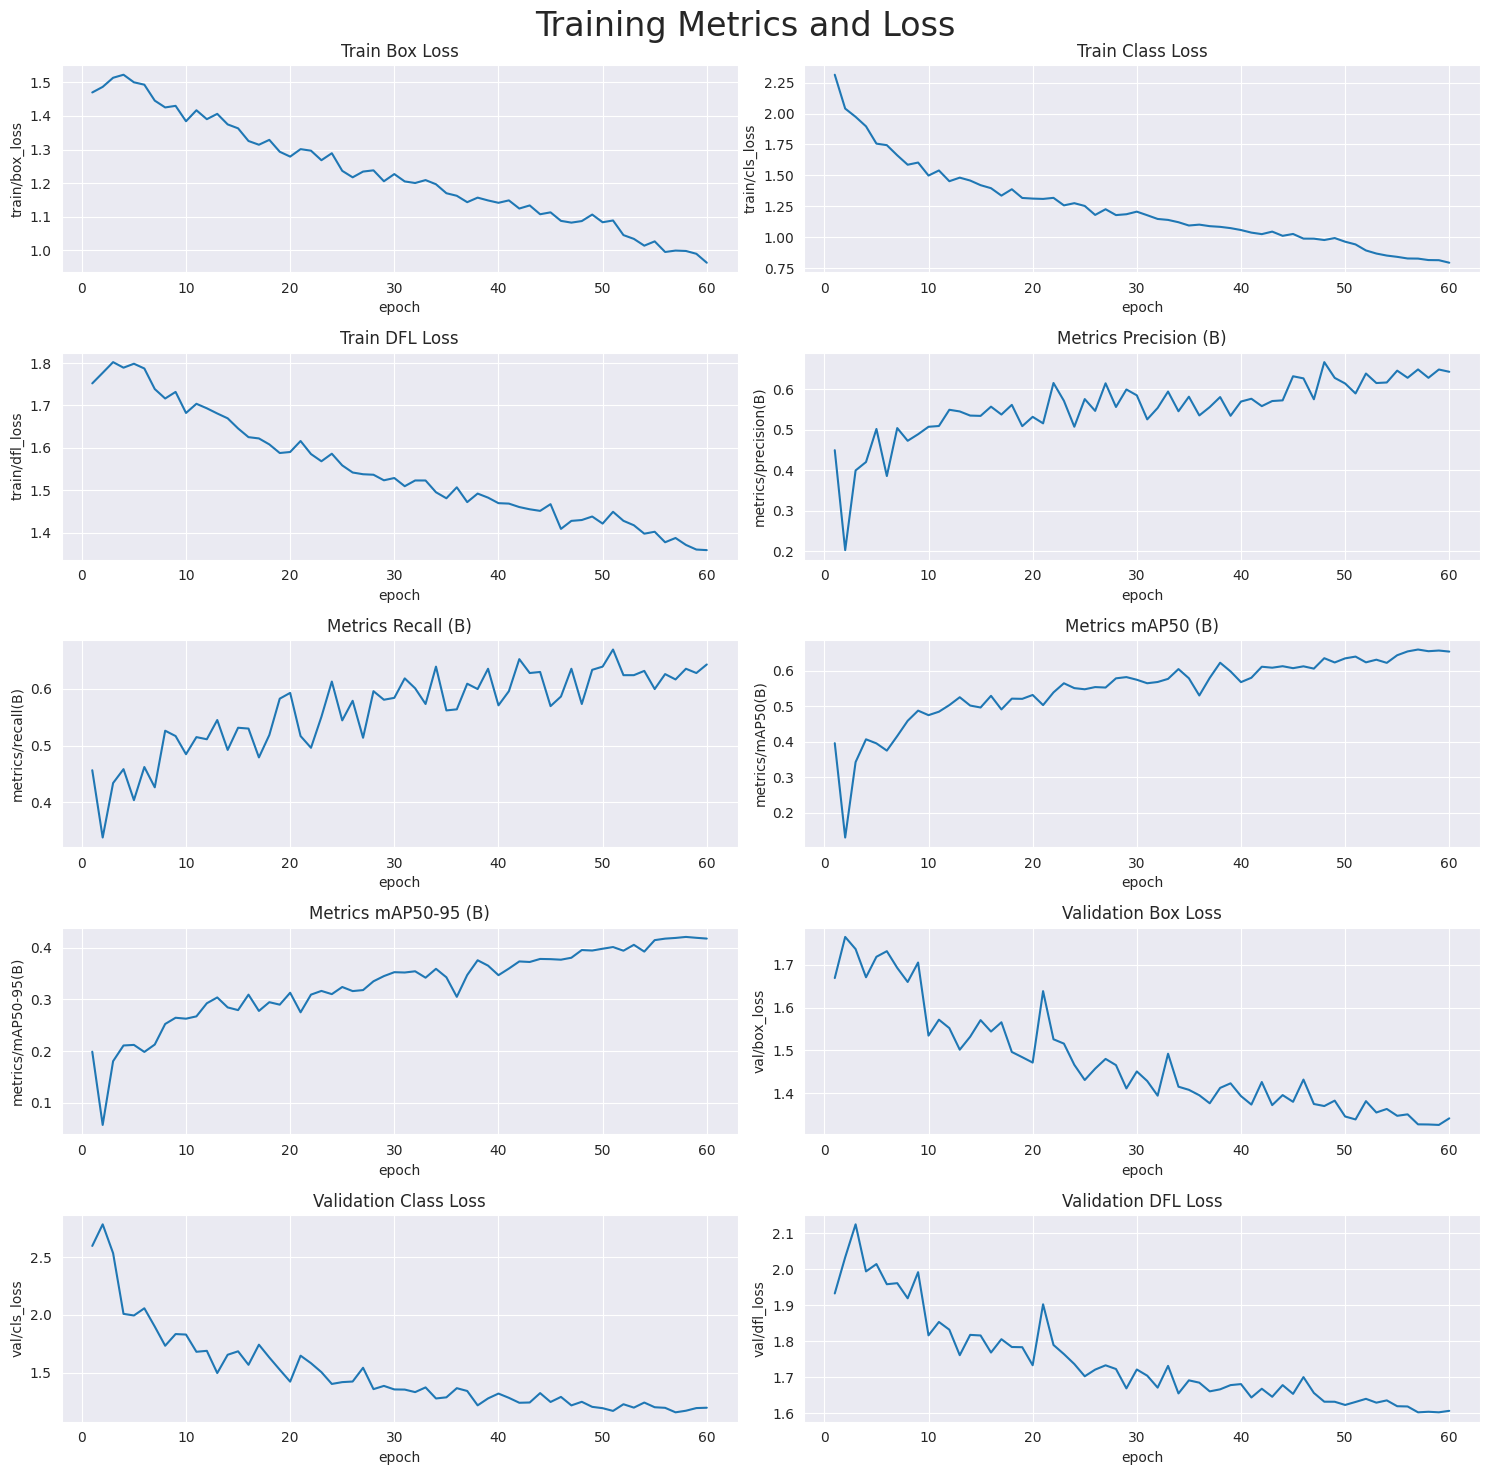

In [14]:
csv_path = '/kaggle/working/runs/detect/train/results.csv'
show_csv_results(csv_path)

# Evaluation of model

In [15]:
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics 8.3.55 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/yolo_dataset_leafdetection/test/labels... 113 images, 0 backgrounds, 0 corrupt: 100%|██████████| 113/113 [00:00<00:00, 1327.09it/s]

val: New cache created: /kaggle/working/yolo_dataset_leafdetection/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


                   all        113        626      0.676      0.698      0.705      0.495
Speed: 0.8ms preprocess, 7.5ms inference, 0.0ms loss, 26.1ms postprocess per image
Results saved to runs/detect/val


## Mean Average Precision metrics

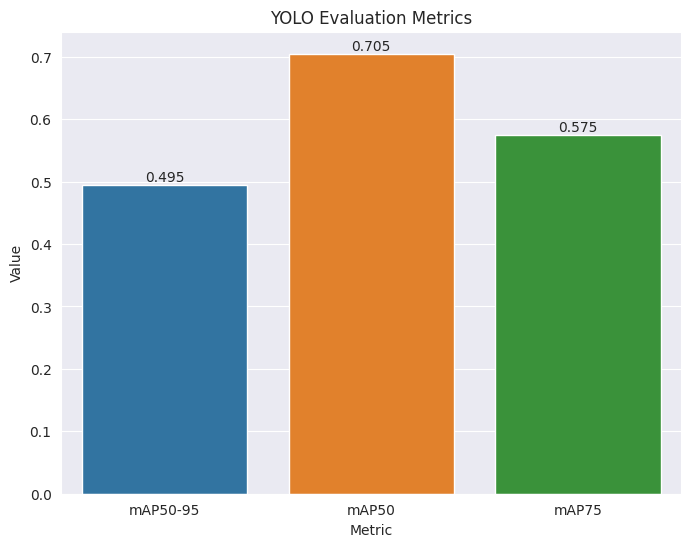

In [16]:
# Show evaluation metrics
show_metrics(metrics)

## Confusion Matrix

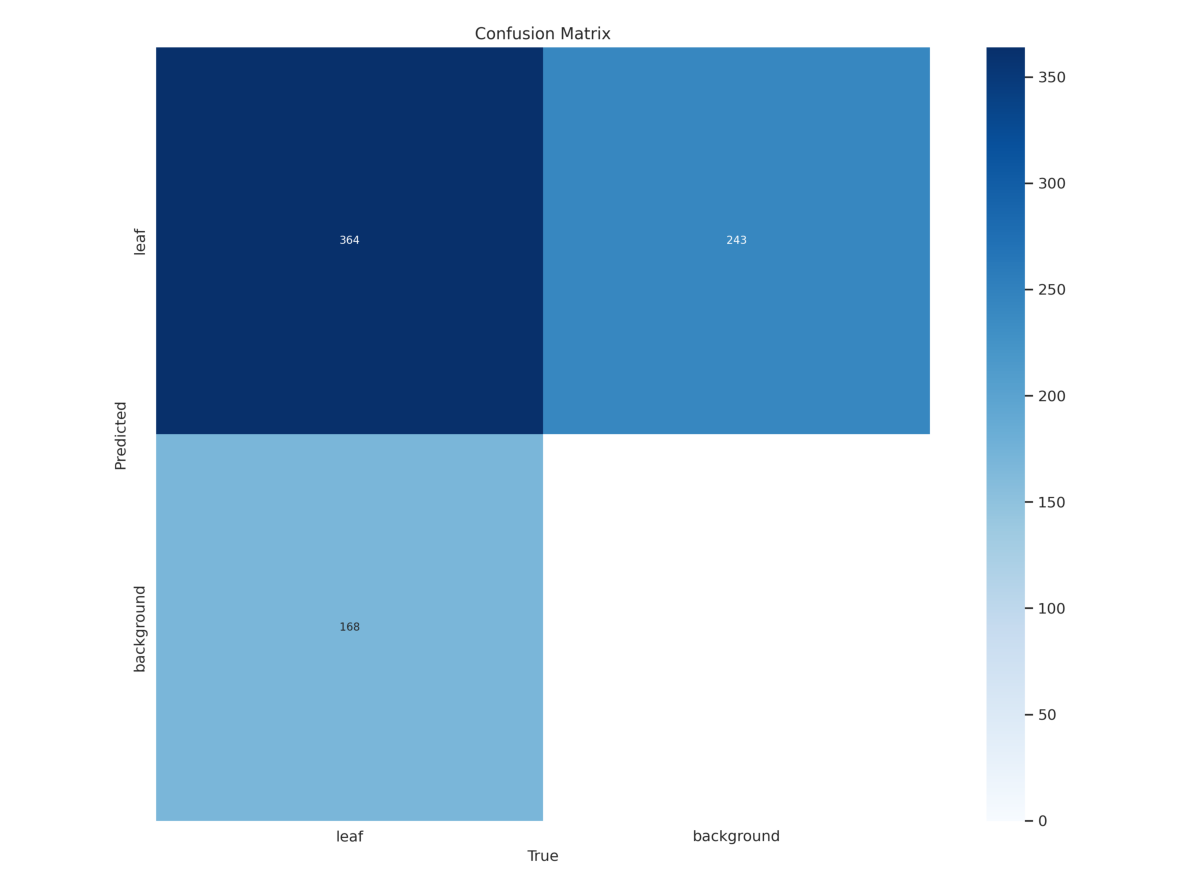

In [17]:
# Reading the confusion matrix image file
matrix_path='/kaggle/working/runs/detect/train/confusion_matrix.png'
# Plotting the confusion matrix image
show_image(matrix_path)

# Making Predictions on Test Images


0: 1024x1024 9 leafs, 6.2ms
Speed: 4.9ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 3 leafs, 6.2ms
Speed: 5.3ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 2 leafs, 6.3ms
Speed: 5.2ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 23 leafs, 6.2ms
Speed: 5.4ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 7 leafs, 6.2ms
Speed: 3.2ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 12 leafs, 6.2ms
Speed: 5.4ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 29 leafs, 6.2ms
Speed: 3.0ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 21 leafs, 6.3ms
Speed: 5.4ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape

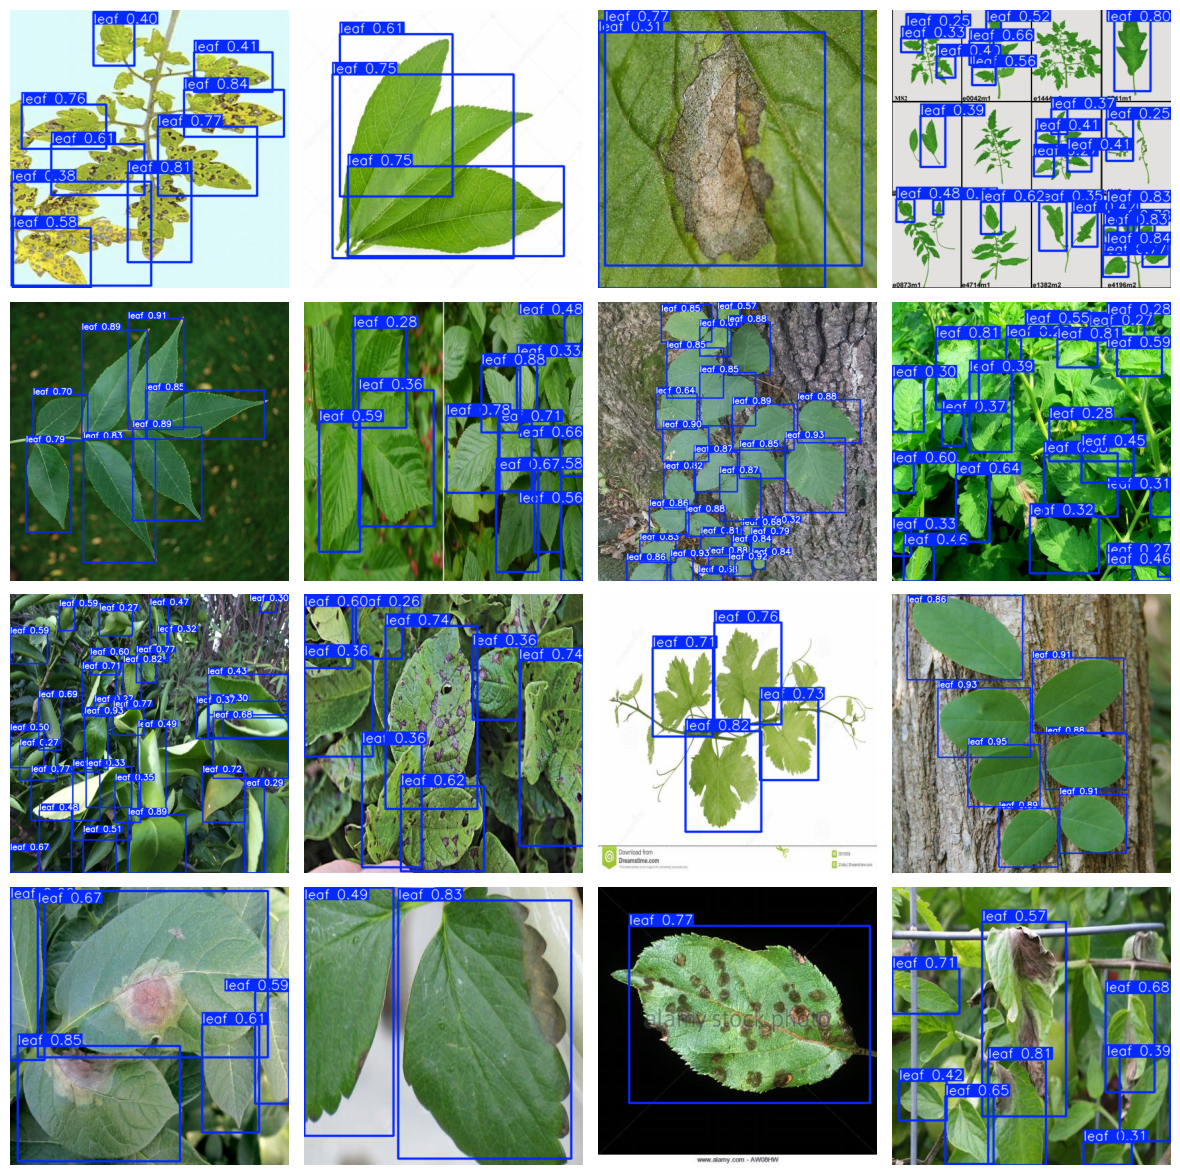

In [18]:
# Define the directory where the custom images are stored
custom_image_dir = '/kaggle/working/yolo_dataset_leafdetection/test/images'

# Detect and display predictions
show_detections(custom_image_dir,num_images=16, rows=4, columns=4)

# Creating and using the TFlite model

## Conversion to TFlite

Ultralytics saves the TFlite model to the path: `/kaggle/working/runs/detect/train/weights/best_saved_model`

In [19]:
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')  # Loading the best performing model
model.export(format='tflite')

Ultralytics 8.3.55 🚀 Python-3.10.13 torch-2.1.2 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/kaggle/working/runs/detect/train/weights/best.pt' with input shape (1, 3, 1024, 1024) BCHW and output shape(s) (1, 5, 21504) (6.0 MB)
requirements: Ultralytics requirements ['tf_keras', 'sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'onnx2tf>1.17.5,<=1.22.3', 'onnxslim>=0.1.31', 'tflite_support', 'onnxruntime-gpu'] not found, attempting AutoUpdate...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 2.0.2 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
arviz 0.17.0 requires numpy<2.0,>=1.22.0, but you have numpy 2.0.2 which is incompatible.
astropy 6.0.0 requires numpy<2,>=1.22, but you have numpy 2.0.2 which is incompatible.
contourpy 1.2.0 requires nu

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.6/136.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 266.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 233.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 243.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 315.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 295.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 188.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 297.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 273.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 243.1 MB/s eta 0:00:00a 0:00:01
   ━━

100%|██████████| 1.11M/1.11M [00:00<00:00, 37.8MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /kaggle/working/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 50.52file/s]


ONNX: starting export with onnx 1.15.0 opset 17...


ONNX: slimming with onnxslim 0.1.45...
ONNX: export success ✅ 1.5s, saved as '/kaggle/working/runs/detect/train/weights/best.onnx' (12.2 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.22.3...


Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 155, Total Ops 410, % non-converted = 37.80 %
 * 155 ARITH ops

- arith.constant:  155 occurrences  (f32: 131, i32: 24)



  (f32: 8)
  (f32: 18)
  (f32: 64)
  (f32: 58)
  (f32: 3)
  (f32: 59)
  (f32: 7)
  (f32: 6)
  (f32: 2)
  (f32: 1)
  (f32: 20)
  (f32: 2)
  (f32: 4)
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 155, Total Ops 541, % non-converted = 28.65 %
 * 155 ARITH ops

- arith.constant:  155 occurrences  (f16: 131, i32: 24)



  (f32: 8)
  (f32: 18)
  (f32: 64)
  (f32: 131)
  (f32: 58)
  (f32: 3)
  (f32: 59)
  (f32: 7)
  (f32: 6)
  (f32: 2)
  (f32: 1)
  (f32: 20)
  (f32: 2)
  (f32: 4)


TensorFlow SavedModel: export success ✅ 99.1s, saved as '/kaggle/working/runs/detect/train/weights/best_saved_model' (30.3 MB)

TensorFlow Lite: starting export with tensorflow 2.15.0...
TensorFlow Lite: export success ✅ 0.0s, saved as '/kaggle/working/runs/detect/train/weights/best_saved_model/best_float32.tflite' (12.0 MB)

Export complete (101.0s)
Results saved to /kaggle/working/runs/detect/train/weights
Predict:         yolo predict task=detect model=/kaggle/working/runs/detect/train/weights/best_saved_model/best_float32.tflite imgsz=1024  
Validate:        yolo val task=detect model=/kaggle/working/runs/detect/train/weights/best_saved_model/best_float32.tflite imgsz=1024 data=/kaggle/working/yolo_dataset_leafdetection/data.yaml  
Visualize:       https://netron.app


'/kaggle/working/runs/detect/train/weights/best_saved_model/best_float32.tflite'

## Predictions with the TFlite model

The predictions generate the results in images located in `/kaggle/working/runs/detect/predict`

In [20]:
# Load a pretrained YOLOv8n model
model = YOLO('/kaggle/working/runs/detect/train/weights/best_saved_model/best_float32.tflite')

# Run inference 
model.predict('/kaggle/input/leaf-detection/test/leaf', save=True, imgsz=height, conf=0.2)

Loading /kaggle/working/runs/detect/train/weights/best_saved_model/best_float32.tflite for TensorFlow Lite inference...



INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


image 1/7 /kaggle/input/leaf-detection/test/leaf/TEST_001.jpg: 1024x1024 85 leafs, 444.7ms
image 2/7 /kaggle/input/leaf-detection/test/leaf/TEST_002.jpg: 1024x1024 75 leafs, 367.1ms
image 3/7 /kaggle/input/leaf-detection/test/leaf/TEST_003.jpg: 1024x1024 15 leafs, 356.7ms
image 4/7 /kaggle/input/leaf-detection/test/leaf/TEST_004.jpg: 1024x1024 74 leafs, 355.3ms
image 5/7 /kaggle/input/leaf-detection/test/leaf/TEST_005.jpg: 1024x1024 89 leafs, 389.8ms
image 6/7 /kaggle/input/leaf-detection/test/leaf/TEST_006.jpg: 1024x1024 4 leafs, 354.6ms
image 7/7 /kaggle/input/leaf-detection/test/leaf/TEST_007.jpg: 1024x1024 29 leafs, 366.2ms
Speed: 5.4ms preprocess, 376.4ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'leaf'}
 obb: None
 orig_img: array([[[ 25,  77,  40],
         [ 18,  75,  37],
         [  6,  72,  37],
         ...,
         [201, 227, 197],
         [205, 229, 199],
         [207, 229, 200]],
 
        [[ 23,  77,  40],
         [ 17,  76,  38],
         [  9,  75,  40],
         ...,
         [200, 228, 198],
         [206, 230, 200],
         [208, 230, 201]],
 
        [[ 22,  79,  41],
         [ 16,  79,  40],
         [ 10,  80,  44],
         ...,
         [201, 229, 199],
         [207, 231, 201],
         [208, 232, 202]],
 
        ...,
 
        [[ 26, 149,  91],
         [ 25, 148,  90],
         [ 26, 148,  88],
         ...,
         [231, 238, 203],
         [238, 244, 209],
         [240, 246, 211]],
 
        [[ 20, 143,  85],
         [ 20, 143,  85],
         [ 21, 143,  83],
         ...,
         [231, 239, 

## Show TFlite model prediction results

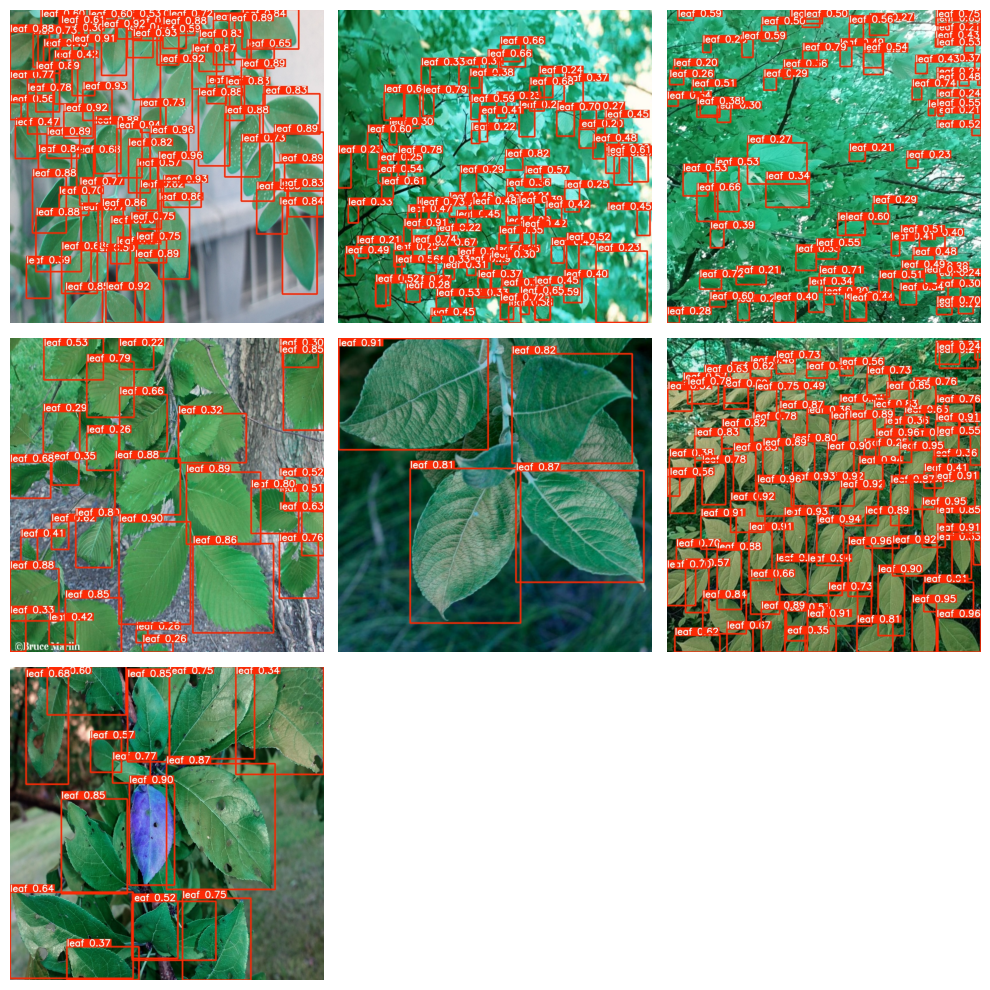

In [21]:
images_dir = '/kaggle/working/runs/detect/predict'
num_images = 7
show_directory_images(images_dir, num_images)

In [22]:
!zip -r output.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/yolo11n.pt (deflated 11%)
  adding: kaggle/working/yolov8n.pt (deflated 9%)
  adding: kaggle/working/calibration_image_sample_data_20x128x128x3_float32.npy (deflated 70%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/detect/ (stored 0%)
  adding: kaggle/working/runs/detect/val/ (stored 0%)
  adding: kaggle/working/runs/detect/val/F1_curve.png (deflated 19%)
  adding: kaggle/working/runs/detect/val/R_curve.png (deflated 17%)
  adding: kaggle/working/runs/detect/val/P_curve.png (deflated 17%)
  adding: kaggle/working/runs/detect/val/confusion_matrix.png (deflated 38%)
  adding: kaggle/working/runs/detect/val/confusion_matrix_normalized.png (deflated 38%)
  adding: kaggle/working/runs/detect/val/val_batch2_pred.jpg (deflated 3%)
  adding: kaggle/working/runs/detect/val/val_batch1_labels.jpg (deflated 1%)
  adding: kaggle/working/runs/detect/val